In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def doublemoon(n, d, r, w): #n为数据集数量，d为双月之间的距离，r为双月半径，w为月亮厚度
    n1 = 10 * n
    w1 = w / 2
    data = np.empty(0)
    
    while data.shape[0] < n:
        tmp_x = 2 * (r + w1) * (np.random.random([n1, 1]) - 0.5)
        tmp_y = (r + w1) * np.random.random([n1, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        idx = np.logical_and(tmp_ds > (r - w1), tmp_ds < (r + w1))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis = 0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis = 0)), axis = 0)
    
    db_moon = data[0: n, :]
    data_t = np.empty([n, 2])
    data_t[:, 0] = data[0: n, 0] + r
    data_t[:, 1] = -data[0: n, 1] - d
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

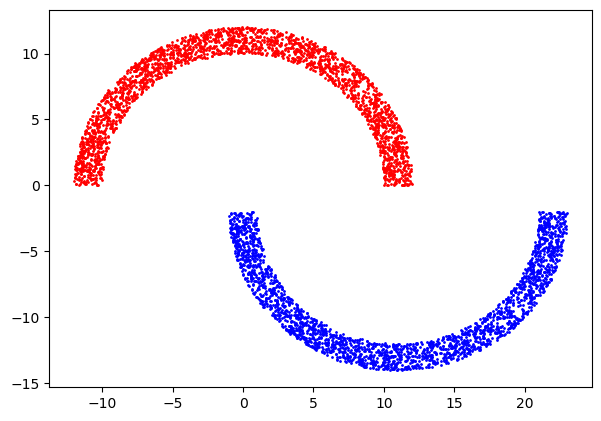

In [3]:
# 生成双月线性可分二分类数据集
num = 5000
x =  doublemoon(n = num // 2, d = 2, r = 11, w = 2)
y = np.concatenate([np.ones([num // 2]), -np.ones([num // 2])])

plt.figure(figsize = (7, 5), dpi = 100)
plt.scatter(x[num // 2:, 0], x[num // 2:, 1], 1, color = 'blue')
plt.scatter(x[: num // 2, 0], x[: num // 2, 1], 1, color = 'red')
plt.show()

In [4]:
# 将数据集随机打乱并分为训练集与测试集
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1)

In [5]:
# rosenblatt的构造
b = 0
w = np.zeros([2], dtype=np.float32)

def rosenblatt(x):
    y = np.dot(w, x) + b
    if y > 0:
        return 1
    else:
        return -1

In [6]:
# 收敛衡量指标mse的构造
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)

In [7]:
# 训练过程
# 权值重置
b = 0
w = np.zeros([2], dtype = np.float32)

# 最大迭代次数
train_step = 10000

# 摘要频率
summary_step = 50
summary = []

# 学习率衰减
lr = 0.1
decay_rate = 0.95

for i in range(0, train_step):
    # 评估模型
    if i % summary_step == 0:
        test_out = [rosenblatt(test) for test in test_x]
        loss = mse(test_y, test_out)
        summary.append(np.array([i, loss])) #用于i和loss
        
    # 从训练集中获取样本
    x1, y1 = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    
    # 得到输出结果
    output = rosenblatt(x1)
    
    # 更新权值
    w = w + lr * (y1 - output) * x1
    b = b + lr * (y1 - output)
    
    # 令阈值为1e-4，当loss不大于1e-4时，可以认为模型已经收敛
    if loss <= 1e-4:  
        print("训练到第%d轮，已经接近收敛" % i)
        break
        
    # 学习率的指数衰减，每1000次衰减一次，
    if (i + 1) % 1000 == 0:
        if lr > 1e-4:
            lr = pow(decay_rate, (i + 1) / 1000) * lr
            print("第%d轮的学习率为%.8f" % (i, lr))
   
summary = np.array(summary)

第999轮的学习率为0.09500000
训练到第1600轮，已经接近收敛


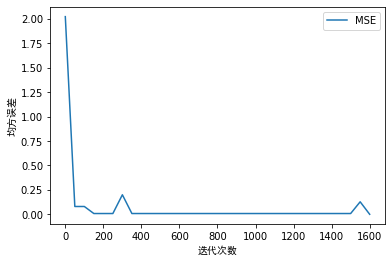

In [8]:
# 绘制mse变化折线图
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc = 'best')
plt.xlabel('迭代次数', fontproperties = 'SimHei')
plt.ylabel('均方误差', fontproperties = 'SimHei')
plt.show()

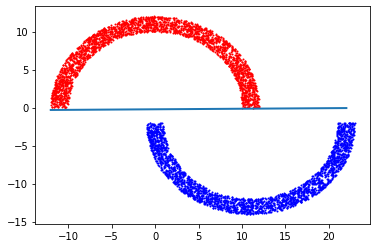

In [9]:
# 绘制决策边界（图中蓝色直线）
plt.scatter(x[num // 2:, 0], x[num // 2:, 1], 1, color='blue')
plt.scatter(x[: num // 2, 0], x[: num // 2, 1], 1, color='red')
left = (-b - (-12) * w[0]) / w[1]
right = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left, right], linewidth = 2)
plt.show()